# CoSP Assignment 1: Turn taking

### Submission details:

* **Deadline: Wednesday 08/11/2017 at 20:00** Please submit your work on time. Late submissions will not be graded.
* You can do the assignment either individually, or in a group of 2 people.
* Submit the .ipynb file containing your code **via email to nadine.theiler@uva.nl using "[CoSP17] Assignment 1" as a subject line**. Rename the .ipynb file so that the file name contains your last name(s), e.g. assignment1_ntheiler.ipynb. If you submit your answers as a group, clearly indicate this in the name of the file, and preferably also in the comment section.
* For every question, it is indicated how many points you can maximally get for it. The total number of points for the assignment is 100. The assignment also contains a bonus question for which you can get 10 points.

### Some technical remarks:
* You should write your code and answers **in this Jupyter notebook**. The blocks for code and text are already created, just click on them and change the content.
* Make sure we can run the notebook. If you can run your notebook from the folder *cosp2017_practical* you downloaded during the introductory practical session without modifications, then your setup should be ok and we should be able to run your notebook too. 
* If you want to run a particular cell in the notebook, make sure you also run the cells above it that it depends on.
* Make sure to put "%pylab inline" somewhere in the beginning of your notebook, such that plots will appear inline.

In [2]:
# import external libraries, don't worry if a warning appears!
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Preliminaries: Timing in turn taking transitions

In the first assignment, we will investigate timing at turn taking transitions in the Switchboard corpus. We can think of a turn transition as a turn by one speaker (the turn yielder) followed by a turn by a different speaker (the turn taker). The time at a turn transition can be negative (if there is a speech overlap), positive (if there is a pause between the two turns), or zero (in which case the turn taker starts talking exactly when the previous speaker stops).

## Plotting simple timing distributions

We can loop through all the dialogue files using the CorpusReader:

In [3]:
# import the corpus reader and read in the corpus
from swda_time import CorpusReader
corpus = CorpusReader('swda_time', 'swda_time/swda-metadata-ext.csv')

We then iterate over all the transcripts, storing the transition timings between the turns. Unfortunately, for some turns there is no timing information in the corpus (see for instance dialogue sw2020, line 43). To prevent shifting the average time between two turns, we will only compute the timing differences between two consecutive turns that both contain information on timing:

In [4]:
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times = []
miss_counts = 0
for transcript in corpus.iter_transcripts(display_progress=True):
    end_prev_turn = transcript.utterances[0].end_turn
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            transition_times.append(transition_time)
        except TypeError:
            # if either the previous or current utterance does not contain timing information, 
            # drop the transition and increase the miss counter
            miss_counts += 1
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index = utterance.end_turn, utterance.turn_index

# percentage of ignored turn transitions is calculated by miss counter 
# divided by total count (transition + miss) times 100 
percentage = (miss_counts / float(len(transition_times) + miss_counts)) * 100
print "We are ignoring %f%% of the turn transitions" % percentage

transcript 645

We are ignoring 28.942721% of the turn transitions


Running the previous block of code creates a list (transition_times) with the timing information of all the turn taking transitions of all the dialogues in the corpus. 

**Question 1 (10pt)**

To get started, extend the code above to compute what percentage of the turn transitions we cannot use because of missing timing information. Uncomment the last line and use it to print the percentage.

We can create a plot of the distribution using the histogram function of matplotlib.pylab:

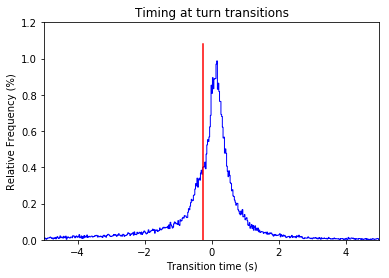

In [5]:
# compute and plot the mean of all transition times
mean = np.mean(transition_times)
plt.axvline(x=mean, ymin=0, ymax=0.9, color='red')

# plot the normalised timing information
n, bins, patches = plt.hist(transition_times, 5000, histtype='step', normed=True, color='blue')
plt.axis([-5, 5, 0, 1.2])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency (%)")
plt.show()

## Plotting timing distributions for different variables

Instead of plotting all the turn transition timings in one plot, we can also compare the timing distributions for different demographic variables. For instance, do the transition times depend on variables such as the gender or the education of the turn taker in the transition? (note that it would also be possible to look at the demographic data of the *turn yielder*; we will not do that in this assignment).

In [6]:
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times_gender = {'FEMALE':[], 'MALE':[]}
for transcript in corpus.iter_transcripts(display_progress=True):
    end_prev_turn = transcript.utterances[0].end_turn
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            transition_times_gender[utterance.caller_sex].append(transition_time)
        except TypeError:
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index = utterance.end_turn, utterance.turn_index

transcript 645


The previous block of code creates a dictionary (transition_times_gender) with two lists of timings, one for female and one for male turn takers. Now we can plot the result:

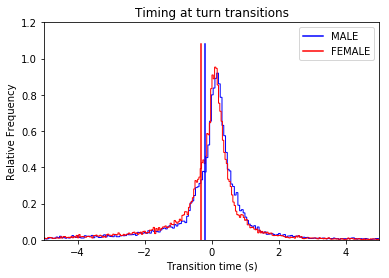

In [7]:
# dictionary for colours
cdict = dict(zip(transition_times_gender.keys(), ['blue','red']))

for var in transition_times_gender:
    mean = np.mean(transition_times_gender[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(transition_times_gender[var], 2000, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 1.2])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency")
plt.legend()

Just looking at two plots is not sufficient to determine if there is a statistically significant difference between the two demographic groups. We will determine this with a standard test for statistical significance, a t-test, assuming unequal variance (if you are unfamiliar with t-tests, look for instance at https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes.2C_unequal_variances). We use the scipy library stats to conduct our statistical tests:

In [8]:
# data
data_f = transition_times_gender['FEMALE']
data_m = transition_times_gender['MALE']

# print mean and sample size of the data
print "Female turn takers:\t mean timing: %f\t sample size: %i" % (np.mean(data_f), len(data_f))
print "Male turn takers:\t mean timing: %f\t sample size: %i\n" % (np.mean(data_m), len(data_m))

# print results for t-test
print "\nt-test assuming unequal variance: T: %f\t p-value :%.4e" % scipy.stats.ttest_ind(data_f, data_m, equal_var=False)

Female turn takers:	 mean timing: -0.325021	 sample size: 25478
Male turn takers:	 mean timing: -0.203277	 sample size: 21191


t-test assuming unequal variance: T: -5.622491	 p-value :1.8939e-08


From the low p-value (lower than the standard threshold of 0.05), we conclude that there is a significant difference between transition times of male and female turn takers: female turn takers in this corpus overlap more with the previous speaker than male turn takers do.

# Assignment

Many interesting questions can be explored by creating and analysing such plots. For instance, what is the influence of age, education or gender? In this assignment, you will investigate the following questions:
* Does the level of education of the turn taker have an impact on the distribution of the timings?
* Is there a difference between male-male and female-female conversations (similar to the analysis in this Language Log post: http://languagelog.ldc.upenn.edu/nll/?p=7997)
* Are males more likely to overlap with females or males, and vice versa?
* One of your own questions

Extend this notebook to contain answers to these questions. You don't have to create any new blocks, but you can use the existing ones by clicking on them and adapting their content. Your extended notebook should contain:
* (Labeled) histograms to support all of your answers. Play with the parameters of the plotting function, such as the number of bins in the histogram, to make the plot legible
* Significance values for the differences you may find

### Education level and timing distributions

**Question 2 (30 pt)**

Is the distribution of timings at turn transitions dependent on the level of education of the turn taker? The education level was coded as 0 for less than high school, 1 for less than college (but not 0), 2 for college (but not 1), 3 for more than college, and 9 for unknown. Ignore the speakers for which the education is unknown.

REMARK: WAS "2 for college (but not 3)"

In [9]:
# put here your code to generate histograms
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times_education = {0:[], 1:[], 2:[], 3:[]}
for transcript in corpus.iter_transcripts(display_progress=True):
    end_prev_turn = transcript.utterances[0].end_turn
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            if utterance.caller_education == 9: continue
            transition_times_education[utterance.caller_education].append(transition_time)
        except TypeError:
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index = utterance.end_turn, utterance.turn_index

transcript 645


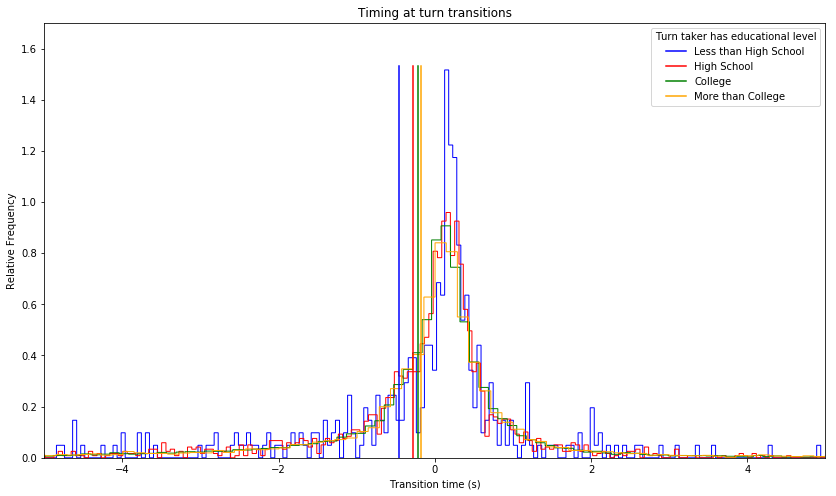

In [100]:
# dictionary for colours
cdict = dict(zip(transition_times_education.keys(), ['blue','red', 'green', 'orange']))
ldict = dict(zip(transition_times_education.keys(), ['Less than High School', 'High School', 'College', 'More than College']))

plt.figure(figsize=(14,8))
for var in transition_times_education:
    mean = np.mean(transition_times_education[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(transition_times_education[var], 750, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 1.7])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency")
labels = ['Less than High School', 'High School', 'College', 'More than College']
plt.legend(labels, title="Turn taker has educational level")

*Put here your interpretation of the histogram, refer to computation of significance values below.*

While from the histogram it seems that the level of education might have a significant impact on the turn-taking behaviour of a speaker, only the distributions of "Less than High School" vs. "More than College" (p=0.043) as well as "High School" vs. "More than College" (p=0.048) are actually just barely significantly different. Here it also should be noted that categories 0 and 1, so "Less than High School" and "High School" have significantly less samples, which leads to the noisy behaviour in the histogram and might reduce the reliability of the significance calculations. 

Assuming they are indeed significantly different, we can observe that a lower degree in education seems to correlate with a larger overlap with the yielding speaker, where callers with less than High School education have the largest overlap with an average of about 450ms.

In [61]:
for key in transition_times_education.keys():
    print ('{} sampples in the "{}" category {}.'.format(len(transition_times_education[key]), ldict[key], key))

395 sampples in the "Less than High School" category 0.
2155 sampples in the "High School" category 1.
28921 sampples in the "College" category 2.
14678 sampples in the "More than College" category 3.


In [57]:
# compute here the significance of the outcome
# data
data = [transition_times_education[0], transition_times_education[1], 
        transition_times_education[2], transition_times_education[3]]

# print mean and sample size of the data
print '"Less than High School" turn takers %i:\t mean timing: %f\t sample size: %i' % (0, np.mean(data[0]), len(data[0]))
print '"High School" turn takers %i:\t\t mean timing: %f\t sample size: %i' % (1, np.mean(data[1]), len(data[1]))
print '"College" turn takers %i:\t\t mean timing: %f\t sample size: %i' % (2, np.mean(data[2]), len(data[2]))
print '"More than College" turn takers %i:\t mean timing: %f\t sample size: %i\n' % (3, np.mean(data[3]), len(data[3]))

# print results for t-test
for i in range(len(transition_times_education.keys())-1):
    for j in range(i+1, len(transition_times_education.keys())):
        results = scipy.stats.ttest_ind(data[i], data[j], equal_var=False)
        print '"{}" vs. "{}": T: {}\t p-value :{p:1.4e}'.format(ldict[i], ldict[j], results[0], p=results[1])

"Less than High School" turn takers 0:	 mean timing: -0.462736	 sample size: 395
"High School" turn takers 1:		 mean timing: -0.274953	 sample size: 2155
"College" turn takers 2:		 mean timing: -0.220167	 sample size: 28921
"More than College" turn takers 3:	 mean timing: -0.178854	 sample size: 14678

"Less than High School" vs. "High School": T: -1.2980423192	 p-value :1.9491e-01
"Less than High School" vs. "College": T: -1.74718138824	 p-value :8.1371e-02
"Less than High School" vs. "More than College": T: -2.02588441502	 p-value :4.3413e-02
"High School" vs. "College": T: -1.22116606416	 p-value :2.2213e-01
"High School" vs. "More than College": T: -1.97257195961	 p-value :4.8621e-02
"College" vs. "More than College": T: -1.53954996715	 p-value :1.2368e-01


### Gender and timing distributions

**Question 3 (30 pt)**

Is there a difference in timing distributions between male-male and female-female conversations?

In [59]:
# put here your code to generate histograms
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times_gender_conversation = {'MALE':[], 'FEMALE':[]}
for transcript in corpus.iter_transcripts(display_progress=True):
    if not transcript.from_caller_sex == transcript.to_caller_sex: continue
    
    end_prev_turn = transcript.utterances[0].end_turn
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            transition_times_gender_conversation[utterance.caller_sex].append(transition_time)
        except TypeError:
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index = utterance.end_turn, utterance.turn_index

transcript 645


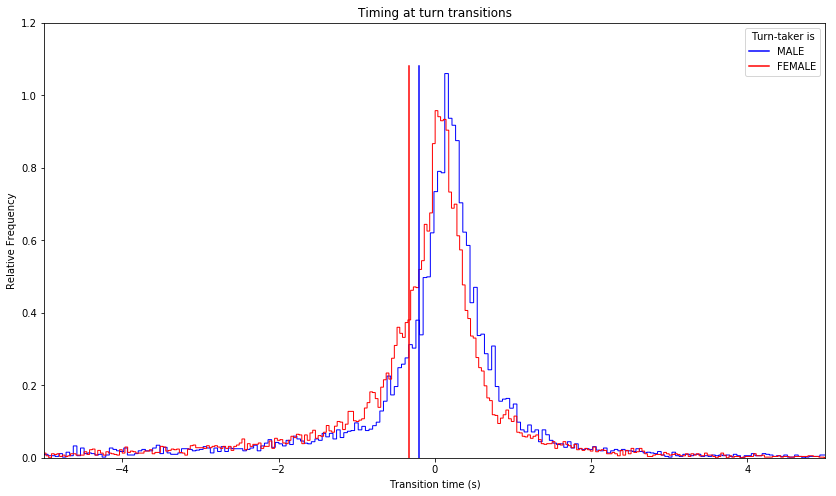

In [99]:
# dictionary for colours
cdict = dict(zip(transition_times_gender_conversation.keys(), ['blue','red']))

plt.figure(figsize=(14,8))
for var in transition_times_gender_conversation:
    mean = np.mean(transition_times_gender_conversation[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(transition_times_gender_conversation[var], 2000, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 1.2])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency")
plt.legend(title="Turn-taker is")

*Put here your interpretation of the histogram, refer to computation of significance values below.*

As shown by results of the significance testing, male-male and female-female conversations differ significantly in their turn-taking behaviour (p << 0.05): In female-female turn transitions, on average turn transitions happen with an overlap of about 300ms while male-male turn-taking takes a little longer (about 200 ms overlap). Still both of them clearly show that the turn taking moment is predicted by the turn-taker in many cases as it does not depend on a pause by the yielding speaker. 

In [48]:
# compute here the significance of the outcome
# data
data_f = transition_times_gender_conversation['FEMALE']
data_m = transition_times_gender_conversation['MALE']

# print mean and sample size of the data
print "Female-Female turn takers:\t mean timing: %f\t sample size: %i" % (np.mean(data_f), len(data_f))
print "Male-Male turn takers:\t\t mean timing: %f\t sample size: %i\n" % (np.mean(data_m), len(data_m))

# print results for t-test
print "\nt-test assuming unequal variance: T: %f\t p-value :%.4e" % scipy.stats.ttest_ind(data_f, data_m, equal_var=False)

Female-Female turn takers:	 mean timing: -0.328338	 sample size: 15465
Male-Male turn takers:		 mean timing: -0.197429	 sample size: 11236


t-test assuming unequal variance: T: -4.641340	 p-value :3.4821e-06


**Question 3 (30pt)**

Is there a difference in timing distributions for female turn taker - male turn yielder, female turn taker - female turn yielder, male turn taker - male turn yielder and male turn taker - male turn yielder?

In [62]:
# put here your code to generate histograms
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times_gender_pairs = {'MALE-MALE':[], 'FEMALE-FEMALE':[], 'MALE-FEMALE':[], 'FEMALE-MALE':[]}
for transcript in corpus.iter_transcripts(display_progress=True):
    end_prev_turn = transcript.utterances[0].end_turn
    prev_turn_sex = transcript.utterances[0].caller_sex
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            transition_times_gender_pairs['{}-{}'.format(prev_turn_sex, utterance.caller_sex)].append(transition_time)
        except TypeError:
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index, prev_turn_sex = utterance.end_turn, utterance.turn_index, utterance.caller_sex        

transcript 645


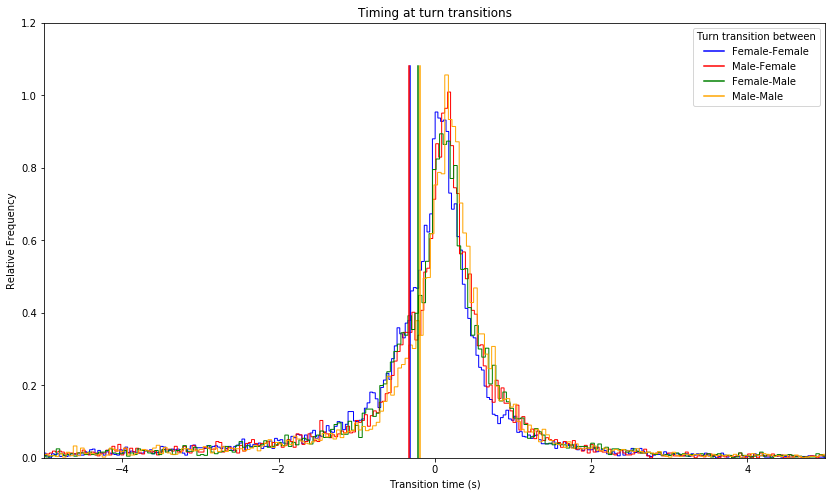

In [98]:
# dictionary for colours
cdict = dict(zip(transition_times_gender_pairs.keys(), ['blue','red', 'green', 'orange']))
ldict = dict(zip(transition_times_gender_pairs.keys(), ['Female-Female', 'Male-Female', 'Female-Male', 'Male-Male']))

plt.figure(figsize=(14,8))
for var in transition_times_gender_pairs:
    mean = np.mean(transition_times_gender_pairs[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(transition_times_gender_pairs[var], 2000, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 1.2])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency")
labels = ['Female-Female', 'Male-Female', 'Female-Male', 'Male-Male']
plt.legend(labels, title="Turn transition between")

*Put here your interpretation of the histogram, refer to computation of significance values below.* 

Only those distributions are significantly different where the turn-takers are different. It therefore appears that the gender of the turn-taker defines the transition behaviour independent of the turn yielder. Female turn-takers appear to take turns faster than males, as was also shown in the first experiment.

In [78]:
# compute here the significance of the outcome
# data
data = [transition_times_gender_pairs['FEMALE-FEMALE'], transition_times_gender_pairs['MALE-FEMALE'], 
        transition_times_gender_pairs['FEMALE-MALE'], transition_times_gender_pairs['MALE-MALE']]
keys = ['FEMALE-FEMALE', 'MALE-FEMALE', 'FEMALE-MALE', 'MALE-MALE']

# print mean and sample size of the data
print 'Female-Female turn transitions:\t mean timing: %f\t sample size: %i' % (np.mean(data[0]), len(data[0]))
print 'Male-Female turn transitions:\t mean timing: %f\t sample size: %i' % (np.mean(data[1]), len(data[1]))
print 'Female-Male turn transitions:\t mean timing: %f\t sample size: %i' % (np.mean(data[2]), len(data[2]))
print 'Male-Male turn transitions:\t mean timing: %f\t sample size: %i\n' % (np.mean(data[3]), len(data[3]))

# print results for t-test
for i in range(len(transition_times_gender_pairs.keys())-1):
    for j in range(i+1, len(transition_times_gender_pairs.keys())):
        results = scipy.stats.ttest_ind(data[i], data[j], equal_var=False)
        print '"{}" vs. "{}": T: {}\t p-value :{p:1.4e}'.format(ldict[labels[i]], ldict[labels[j]], results[0], p=results[1])

Female-Female turn transitions:	 mean timing: -0.320406	 sample size: 15526
Male-Female turn transitions:	 mean timing: -0.332222	 sample size: 9952
Female-Male turn transitions:	 mean timing: -0.219633	 sample size: 9914
Male-Male turn transitions:	 mean timing: -0.188899	 sample size: 11277

"Female-Female" vs. "Male-Female": T: 0.408770264965	 p-value :6.8271e-01
"Female-Female" vs. "Female-Male": T: -3.40951963795	 p-value :6.5218e-04
"Female-Female" vs. "Male-Male": T: -4.65900030101	 p-value :3.1965e-06
"Male-Female" vs. "Female-Male": T: -3.28260642689	 p-value :1.0303e-03
"Male-Female" vs. "Male-Male": T: -4.32222645138	 p-value :1.5517e-05
"Female-Male" vs. "Male-Male": T: -0.911242581036	 p-value :3.6218e-01


## Bonus

**Bonus Question (10pt)**

Define your own question here.

One of the additional callers statistics recorded in the data set is their birhtday. Given this information, we want to analyse if the age of a turn-taker affects the turn-taking behaviour. 

In oder to do so in a sensible fashion, we checked the statistics of distribution of birth years of callers which ranges from 1924 to 1972, spanning 48 years. We decided to divide this distribution into four equal-sized groups, each covering 12 years. 

In [83]:
from collections import Counter
import datetime

def get_age_group(birthdate):
    try: birthyear = birthdate.year
    except AttributeError: birthyear = birthdate
    if birthyear <= 1936:
        return 1936
    elif birthyear <= 1948:
        return 1948
    elif birthyear <= 1960:
        return 1960
    else: return 1972

In [81]:
ages = []
for transcript in corpus.iter_transcripts(display_progress=True):
    ages.append(transcript.from_caller_birth_year.year)
    ages.append(transcript.to_caller_birth_year.year)
    
print(Counter(ages))

transcript 645

Counter({1963: 80, 1962: 68, 1941: 65, 1961: 59, 1965: 58, 1956: 52, 1964: 51, 1958: 49, 1957: 45, 1959: 43, 1960: 43, 1942: 40, 1955: 37, 1954: 35, 1947: 33, 1940: 32, 1950: 32, 1967: 30, 1943: 29, 1945: 28, 1952: 28, 1966: 28, 1969: 24, 1933: 23, 1949: 23, 1939: 22, 1946: 22, 1951: 22, 1971: 21, 1937: 19, 1935: 17, 1968: 17, 1944: 16, 1953: 16, 1970: 16, 1936: 12, 1938: 11, 1948: 9, 1931: 7, 1924: 6, 1972: 6, 1930: 5, 1934: 4, 1932: 1})


In [84]:
age_groups = []
for transcript in corpus.iter_transcripts(display_progress=True):
    age_groups.append(get_age_group((transcript.from_caller_birth_year.year)))
    age_groups.append(get_age_group((transcript.to_caller_birth_year.year)))
    
print(Counter(age_groups))

transcript 645

Counter({1972: 458, 1960: 425, 1948: 326, 1936: 75})


In [85]:
# put here your code to generate histograms
# iterate over all transcripts in the corpus and compute the turn taking timings
transition_times_age_group = {1936:[], 1948:[], 1960:[], 1972:[]}
for transcript in corpus.iter_transcripts(display_progress=True):
    end_prev_turn = transcript.utterances[0].end_turn
    cur_turn_index = transcript.utterances[0].turn_index
    
    # loop over all utterances
    for utterance in transcript.utterances:
        # check if turn transition took place
        if utterance.turn_index == cur_turn_index:
            end_prev_turn = utterance.end_turn
            continue
        
        # compute transition time
        try:
            transition_time = utterance.start_turn - end_prev_turn
            age_group = get_age_group(utterance.caller_birth_year)
            transition_times_age_group[age_group].append(transition_time)
        except TypeError:
            pass
  
        # reset turn index and end of turn
        end_prev_turn, cur_turn_index = utterance.end_turn, utterance.turn_index    

transcript 645


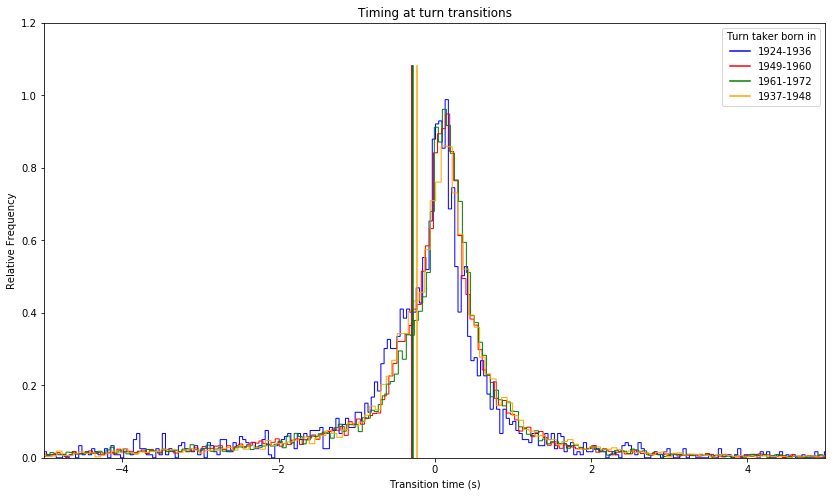

In [97]:
# dictionary for colours
cdict = dict(zip(transition_times_age_group.keys(), ['blue','red', 'green', 'orange']))
ldict = dict(zip(transition_times_age_group.keys(), ['1924-1936', '1949-1960', '1961-1972', '1937-1948']))

plt.figure(figsize=(14,8))
for var in transition_times_age_group:
    mean = np.mean(transition_times_age_group[var])
    plt.axvline(x=mean, ymin=0, ymax=0.9, label=str(var), color=cdict[var])
    n, bins, patches = plt.hist(transition_times_age_group[var], 1500, histtype='step', normed=True, color=cdict[var])
plt.axis([-5, 5, 0, 1.2])
plt.title("Timing at turn transitions")
plt.xlabel("Transition time (s)")
plt.ylabel("Relative Frequency")
labels = ['1924-1936', '1949-1960', '1961-1972', '1937-1948']
plt.legend(labels, title="Turn-taker born in")

Put here your interpretation of the histogram, refer to computation of significance values below.

The significance testing results here show that only two distributions are significantly different, that of turn-takers born between 1937-1948 and those born in the next period, between 1949-1960 (p=0.01). Both of them are reasonalby sized groups, so we can assume this result to be reliable. According to the histogram, those turn takers born in the former period have a little less overlap with the turn-yielders (220ms vs. 300ms).

In [96]:
# compute here the significance of the outcome
# data
data = [transition_times_age_group[1936], transition_times_age_group[1948], 
        transition_times_age_group[1960], transition_times_age_group[1972]]
keys = [1936, 1948, 1960, 1972]

# print mean and sample size of the data
print 'Turn takers born in 1924-1936: \t mean timing: %f\t sample size: %i' % (np.mean(data[0]), len(data[0]))
print 'Turn takers born in 1937-1948:\t mean timing: %f\t sample size: %i' % (np.mean(data[1]), len(data[1]))
print 'Turn takers born in 1949-1960:\t mean timing: %f\t sample size: %i' % (np.mean(data[2]), len(data[2]))
print 'Turn takers born in 1961-1972:\t mean timing: %f\t sample size: %i\n' % (np.mean(data[3]), len(data[3]))

# print results for t-test
for i in range(len(transition_times_age_group.keys())-1):
    for j in range(i+1, len(transition_times_age_group.keys())):
        results = scipy.stats.ttest_ind(data[i], data[j], equal_var=False)
        print '"{}" vs. "{}": T: {}\t p-value :{p:1.4e}'.format(ldict[keys[i]], ldict[keys[j]], results[0], p=results[1])

Turn takers born in 1924-1936: 	 mean timing: -0.293873	 sample size: 2902
Turn takers born in 1937-1948:	 mean timing: -0.222115	 sample size: 11365
Turn takers born in 1949-1960:	 mean timing: -0.295835	 sample size: 16191
Turn takers born in 1961-1972:	 mean timing: -0.272748	 sample size: 16211

"1924-1936" vs. "1937-1948": T: -1.56410564896	 p-value :1.1786e-01
"1924-1936" vs. "1949-1960": T: 0.0443085630979	 p-value :9.6466e-01
"1924-1936" vs. "1961-1972": T: -0.483138573865	 p-value :6.2902e-01
"1937-1948" vs. "1949-1960": T: 2.53964657902	 p-value :1.1103e-02
"1937-1948" vs. "1961-1972": T: 1.79600192438	 p-value :7.2507e-02
"1949-1960" vs. "1961-1972": T: -0.905778621225	 p-value :3.6506e-01
